# Simulation fo qubit-cavity dynamics


## 0 Notation, units, and conventions

| symbol              | meaning                               | units in code                                       |
| ------------------- | ------------------------------------- | --------------------------------------------------- |
| $\hbar = 1$         | natural units                         | –                                                   |
| **time**            | 1 ns                                  | ⇒ angular-frequencies are **rad ns⁻¹**              |
| $a_q,\,a_q^\dagger$ | qubit annihilation / creation         | 3-level Duffing truncation                          |
| $a_r,\,a_r^\dagger$ | cavity photon annihilation / creation | 5 Fock states                                       |
| $g$                 | transverse qubit–cavity coupling      | $2\pi\times100\text{ MHz}=0.628\text{ rad ns}^{-1}$ |
| $\alpha$            | transmon anharmonicity                | $2\pi\times(-300\text{ MHz})$                       |
| $κ$                 | cavity linewidth                      | $2\pi\times2\text{ MHz}$                            |

Throughout, operators carry an explicit tensor structure

$$
b_q = a_q\otimes\mathbb 1_r,\qquad
A_r = \mathbb 1_q\otimes a_r ,
$$

so a single `qutip.Qobj` acts on the full
$|m\!>\otimes|n_r\!>$ basis.

---

## 1 Bare Hamiltonian

$$
H_0  \;=\;
\underbrace{\omega_q\,a_q^\dagger a_q + \tfrac{\alpha}{2}a_q^{\dagger2}a_q^{2}}
_{\displaystyle H_{\text{Duffing}}}
\;+\;
\underbrace{\omega_r\,a_r^\dagger a_r}_{\displaystyle H_{\text{cav}}}\;,
$$

$$
H_1  \;=\; g\bigl(a_q^\dagger a_r + a_q a_r^\dagger\bigr).
$$

* $H_0$ is block-diagonal in the **photon number** $n_r$.
* $H_1$ conserves the *total* excitation number $n_q+n_r$ but couples neighbouring blocks.

Detuning

$$
\Delta_{01} \;=\; \omega_q-\omega_r = 2\pi\times(-2.5\text{ GHz}),
$$

so $|\Delta_{01}| \gg g$ ⇒ the *dispersive* approximation is justified.

---

## 2 Schrieffer–Wolff (SW) transformation

### 2.1  Goal

Find a unitary $e^{S}$ that cancels the **first-order** block-off-diagonal terms:

$$
H_{\text{eff}}
= e^{S}\,(H_0+H_1)\,e^{-S}
= H_0 + \tfrac12\,[S,H_1] \;+\; \mathcal O(g^3).
$$

Choose $S$ s.t.

$$
[S,H_0] = -H_1
\;\;\Longrightarrow\;\;
S_{mn}=\frac{(H_1)_{mn}}{E_m-E_n}
\quad(m\neq n).
$$

The code:

```python
evals, evecs = h0.eigenstates()
S_mn = (⟨m|H1|n⟩)/(E_m-E_n)               # Eq. (↑)
s_op = basis↔eigen transform
H_eff = H0 + ½ [S_op, H1]                # Eq. (initial)
```

### 2.2  Dispersive parameters extracted from $H_{\text{eff}}$

* **Dressed qubit frequency**

  $$
  f_{01}^{\text{(disp)}}=\frac{E_1-E_0}{2\pi}=4.392\text{ GHz}.
  $$

* **Effective anharmonicity**

  $$
  \alpha_{\text{eff}}/2\pi
  =\bigl(E_2-E_1-f_{01}h\bigr)/2\pi
  =-296\text{ MHz}.
  $$

* **Cavity pull (χ-shift)**

  Evaluate energies with 0 / 1 photon in the resonator:

  $$
  χ = \tfrac12\bigl(\omega_r^{(1)}-\omega_r^{(0)}\bigr)
     = -1.44\text{ MHz}.
  $$

These numbers match the print-out in the script.

---

## 3 Dressed qubit drive in the 3-level manifold

### 3.1  Project the effective Hamiltonian

Keep only the $\{|0,0\rangle,|1,0\rangle,|2,0\rangle\}$ block:

```python
Hq3 = H_eff[zero_ph_mask, zero_ph_mask]
```

### 3.2  Dressed ladder operator

Rotate the bare dipole once,

$$
b_{\text{SW}} = b_q + [S,b_q],
$$

then project:

```python
b3 =  (b_q + commutator(S_op,b_q))[zero_ph_mask,zero_ph_mask]
```

### 3.3  Rotating frame & envelope

$$
H_{\text{rot}} = H_{q3} - \hbar\omega_d\,\hat n_3
,\quad
\omega_d = 2\pi f_{01},
\qquad
\Omega(t)=\frac{Ω_R}{2}\;\text{flat\_top}(t),
$$

$$
H_{\text{drive}}(t)=\Omega(t)\,(b_3+b_3^\dagger).
$$

The automatic search

```python
find_pi_time()
```

sweeps $t$ to locate the first maximum of $P_1(t)$;
answer ≈ 36 ns for these parameters.

---

### 3.4  Dressed T₁ channel

Bare cascade
$\{|1\rangle\!\to|0\rangle,\;|2\rangle\!\to|1\rangle\}$
becomes, to first order,

$$
C_{10}^{(\text{SW})}=C_{10}+[S,C_{10}],\qquad
C_{21}^{(\text{SW})}=C_{21}+[S,C_{21}],
$$

then re-projected to the qubit sub-space.

The Lindblad part in the master equation is

$$
\mathcal L\rho
=\sum_k\Gamma_k\Bigl(
  C_k\rho C_k^\dagger-\tfrac12\{C_k^\dagger C_k,\rho\}
\Bigr),
$$

with rates $Γ_1,2Γ_1$.

Because `Gamma1 = 0` in the final code, the evolution is unitary; the dressed forms are kept for completeness.

---

## 4 Homodyne measurement in one-shot rotating frame 

### 4.1  Dressed cavity operator

$$
a_{\text{SW}} = a_r + [S,a_r].
$$

### 4.2  Enter the LO frame once

$$
U(t)=\exp\!\bigl[i\omega_m t\,(a_{\text{SW}}^\dagger a_{\text{SW}}+n_q)\bigr],
\qquad
\omega_m \approx \omega_r^{(0)} .
$$

Hence

$$
H_{\text{meas}}^{(\text{rot})}
= H_{\text{eff}}
- \hbar\omega_m\,(a_{\text{SW}}^\dagger a_{\text{SW}}+n_q).
$$

### 4.3  Drive term

Constant envelope $A_{\text{meas}}=κ$ for
$0\le t\le t_{\text{meas}}$ acts as

$$
H_{\text{drive}}(t) = A_{\text{meas}}\,
      \bigl(a_{\text{SW}} + a_{\text{SW}}^\dagger\bigr).
$$

### 4.4  Collapse operator

Single cavity decay channel

$$
C_\kappa = \sqrt{κ}\;a_{\text{SW}}.
$$

If you later re-enable qubit $T_1$, append the dressed $C_{10},C_{21}$.

### 4.5  Measured quadratures in the same frame

$$
\hat I = a_{\text{SW}} + a_{\text{SW}}^\dagger,\qquad
\hat Q = -i\bigl(a_{\text{SW}} - a_{\text{SW}}^\dagger\bigr).
$$

Time traces $\langle I(t)\rangle,\langle Q(t)\rangle$ are evaluated for

* **ground preparation** – density matrix $\rho_{|0〉}$
* **excited preparation** – density matrix $\rho_{|1〉}$

which were obtained from Section 3.

---



## 6 Accuracy hierarchy and limits

| retained term                   | scaling             | kept?       |
| ------------------------------- | ------------------- | ----------- |
| dispersive shift $χ \sim g^2/Δ$ | $10^{-2}$–$10^{-3}$ | ✓ (`H_eff`) |
| ac-Stark / Bloch-Siegert        | $g^2/Δ$             | ✓ (`H_eff`) |
| 3rd-order terms $∝ g^3/Δ^2$     | $<10^{-4}$          | ✗           |
| dressed collapse $C+[S,C]$      | $g/Δ$               | ✓           |
| dressed drive $b+[S,b]$         | $g/Δ$               | ✓           |

The model is therefore self-consistent up to **second order** in $g/Δ$, which is the dispersive regime’s standard accuracy.

---

### Checklist: where SW is used

| operator     | bare            | rotated              | project | code line      |
| ------------ | --------------- | -------------------- | ------- | -------------- |
| Hamiltonian  | $H_0,H_1$       | **$H_{\text{eff}}$** | –       | `H_eff = …`    |
| qubit dipole | $b_q$           | $b_q+[S,b_q]$        | 3-level | `b_sw … b3`    |
| number oper. | $n_q$           | $n_q+[S,n_q]$        | 3-level | `n_sw … n3`    |
| cavity field | $a_r$           | $a_r+[S,a_r]$        | 3×Nc    | `a_sw`         |
| T₁ jumps     | $C_{10},C_{21}$ | $+\,[S,C]$           | 3-level | `C10_d_full …` |
| κ jump       | $a_r$           | $a_{\text{SW}}$      | 3×Nc    | `c_ops = …`    |

Everything that appears in the master equation evolves in the **same dispersive basis**, guaranteeing energy-conserving secular terms and eliminating spurious leakage at order $g/Δ$.




In [21]:
# ============================================================
#  Schrieffer–Wolff‑based qubit‑cavity simulator pipeline
#  -------------------------------------------------------
#  One file, minimal external dependencies: NumPy, QuTiP, Matplotlib
#  1.  Build bare Duffing‑transmon + cavity Hamiltonian
#  2.  Run SW transform  → dressed (dispersive) parameters
#  3.  Qubit drive (π / 2π) in 3‑level space, obtain final states
#  4.  Measurement pulse in dispersive frame, obtain ⟨I(t)⟩,⟨Q(t)⟩
#  5.  Inject coloured phase noise + integrate → I/Q clouds
# ============================================================

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from numpy.fft import ifft
from numpy.random import default_rng

# ──────────────────────────────────────────────────────────────
# 0. Global constants & helper utilities
# ──────────────────────────────────────────────────────────────
PI2 = 2 * np.pi

def flat_top(t, rise_ns=3, amp=1.0):
    """Simple 3‑ns linear rise, flat afterwards."""
    return amp * (t / rise_ns if t < rise_ns else 1.0)

# ──────────────────────────────────────────────────────────────
# 1.  Bare Hamiltonian & parameters
# ──────────────────────────────────────────────────────────────
Nq, Nc = 3, 5                           # 3 transmon levels, 0‑…9 photons

# bare (lab‑frame) parameters  [rad ns⁻¹]
w_q   = PI2 * 4.5            # 4.5 GHz ↔ 1 ns⁻¹ units
w_r   = PI2 * 7.0            # 7   GHz
alpha = -PI2 * 0.3           # ‑300 MHz anharmonicity
g     = PI2 * 0.100          # 100 MHz coupling
kappa = PI2 * 2e-3           # 2   MHz cavity linewidth
Gamma1= 0*PI2 * 1e-5           # 10  kHz qubit T1‑rate

# QuTiP operators (bare basis)
a_q  = qt.destroy(Nq)
a_r  = qt.destroy(Nc)
I_q, I_r = qt.qeye(Nq), qt.qeye(Nc)

b_q  = qt.tensor(a_q, I_r)
A_r  = qt.tensor(I_q, a_r)

n_q = b_q.dag() * b_q
H_q = w_q*n_q + alpha * b_q.dag()*b_q.dag()*b_q*b_q
H_r = w_r * (A_r.dag()*A_r)
H0  = H_q + H_r
H1  = g*(b_q.dag()*A_r + b_q*A_r.dag())

# ──────────────────────────────────────────────────────────────
# 2.  Schrieffer–Wolff transform (2nd order) – returns H_eff & S
# ──────────────────────────────────────────────────────────────

def effective_hamiltonian_sw(h0, h1, return_S=False):
    """
    Calculates the second-order effective Hamiltonian using the Schrieffer-Wolff (SW) transformation.

    The SW transformation finds an effective Hamiltonian for a low-energy subspace
    by eliminating the first-order coupling between the low- and high-energy subspaces.
    The second-order effective Hamiltonian is given by:
    H_eff = H_0 + (1/2) * [S, H_1]
    where S is the generator of the transformation, satisfying [S, H_0] = H_1.

    Args:
        h0 (Qobj): The unperturbed, diagonal part of the Hamiltonian. Its eigenstates
                   define the different energy subspaces.
        h1 (Qobj): The perturbation (interaction) part of the Hamiltonian that
                   couples the subspaces.

    Returns:
        Qobj: The effective Hamiltonian, accurate to second order in the perturbation.
    """
    print("Performing Schrieffer-Wolff transformation...")

    # Step 1: Find the eigenvalues and eigenvectors of the unperturbed Hamiltonian H0.
    # These define the energy basis in which the transformation is most easily calculated.
    evals, evecs = h0.eigenstates()

    # Step 2: Construct the SW generator S. The matrix elements of S in the eigenbasis of H0
    # are given by S_mn = <m|H1|n> / (E_m - E_n), where E_m and E_n are the eigenvalues.
    s_matrix = np.zeros_like(h0.full(), dtype=complex)
    
    # Transform the interaction Hamiltonian H1 into the eigenbasis of H0.
    h1_eb = h1.transform(evecs)

    # Get the number of states from the shape of the hamiltonian
    num_states = h0.shape[0]

    for m in range(num_states):
        for n in range(num_states):
            # The generator S should only connect states with different unperturbed energies.
            energy_diff = evals[m] - evals[n]
            if abs(energy_diff) > 1e-9:  # Avoid division by zero for degenerate states
                s_matrix[m, n] = h1_eb[m, n] / energy_diff

    # Create the generator Qobj in the eigenbasis and transform it back to the original basis.
    s_eb = qt.Qobj(s_matrix, dims=h0.dims)
    s_op = s_eb.transform(evecs, True)

    # Step 3: Calculate the second-order effective Hamiltonian.
    # The commutator gives the second-order correction.
    h_eff = h0 + 0.5 * qt.commutator(s_op, h1)
    
    print("Transformation complete.")
    if return_S:
        return h_eff, s_op              # NEW: also hand back S
    return h_eff

H_eff, S_op = effective_hamiltonian_sw(H0, H1, return_S=True)

# Dressed parameters (0/1/2 with zero cavity photons)
zero_idx = [k*Nc for k in range(Nq)]
E = np.linalg.eigvalsh(H_eff.full()[np.ix_(zero_idx, zero_idx)])
f01 = (E[1] - E[0]) / PI2      # GHz
alpha_eff = (E[2]-E[1] - f01*PI2) / PI2

# dressed cavity pull
one_ph_idx = [k*Nc + 1 for k in range(Nq)]
E1ph = np.diag(H_eff.full()[np.ix_(one_ph_idx, one_ph_idx)]).real
w_r0 = (E1ph[0] - E[0]) / PI2
w_r1 = (E1ph[1] - E[1]) / PI2
chi  = (w_r1 - w_r0)/2

print(f"Dressed f01 = {f01:.4f} GHz, α = {alpha_eff*1e3:.1f} MHz,  χ/π = {chi*1e3:.1f} MHz")



# ──────────────────────────────────────────────────────────────
# 3.  Qubit drive (3‑level) in zero‑photon manifold
#     • automatic π‑time calibration
# ──────────────────────────────────────────────────────────────
zero_ph_mask = [0*Nc, 1*Nc, 2*Nc]
Hq3 = qt.Qobj(H_eff.full()[np.ix_(zero_ph_mask, zero_ph_mask)], dims=[[Nq],[Nq]])

# dressed ladder operator in the zero‑photon sub‑block
# first-order SW rotation of b_q
b_sw = b_q + qt.commutator(S_op, b_q)
# project to the zero-photon manifold
b3 = qt.Qobj(b_sw.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
             dims=[[Nq],[Nq]])


Ω_R   = 50*kappa/2                      # Rabi rate  (rad/ns)
Hd_q  = [b3 + b3.dag(),
         lambda t, args: 0.5*Ω_R*flat_top(t)]   # ½ Ω σₓ envelope

zero_ph_mask = [k*Nc for k in range(Nq)]       # indices 0, Nc, 2Nc
n_sw = n_q + qt.commutator(S_op, n_q)          # usually tiny
n3    = qt.Qobj(n_sw.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
                dims=[[Nq],[Nq]])
H0_rot = Hq3 - f01*PI2 * n3


def proj(m, n, d=3):
    """Return |m⟩⟨n| projector in a d-level Hilbert space."""
    return qt.basis(d, m) * qt.basis(d, n).dag()

I_r = qt.qeye(Nc)                                 # cavity identity

C10_full = qt.tensor(proj(0, 1), I_r)             # dims [[3,Nc],[3,Nc]]
C21_full = qt.tensor(proj(1, 2), I_r)

# ------------------------------------------------------------------
# 2.  First-order SW dressing:  C_dressed = C + [S, C]
# ------------------------------------------------------------------
C10_d_full = (C10_full + qt.commutator(S_op, C10_full)).tidyup()
C21_d_full = (C21_full + qt.commutator(S_op, C21_full)).tidyup()

# ------------------------------------------------------------------
# 3.  Project the dressed operators back to the zero-photon subspace
# ------------------------------------------------------------------
C10_d = qt.Qobj(C10_d_full.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
                dims=[[Nq],[Nq]])
C21_d = qt.Qobj(C21_d_full.full()[np.ix_(zero_ph_mask, zero_ph_mask)],
                dims=[[Nq],[Nq]])

# ------------------------------------------------------------------
# 4.  Collapse-operator list
# ------------------------------------------------------------------
c_ops_q = [np.sqrt(Gamma1)   * C10_d,          # |1⟩→|0⟩
           np.sqrt(2*Gamma1) * C21_d]          # |2⟩→|1⟩  (√2 rate)


def qubit_state(t_ns: float):
    """Return 3×3 density matrix after driving for t_ns (ns)."""
    tlist = np.linspace(0, t_ns, int(t_ns)+1)
    res   = qt.mesolve([H0_rot, Hd_q], qt.basis(3,0), tlist, c_ops_q)
    return res.states[-1]

def find_pi_time(t_max=120, dt=0.25):
    """Scan 0…t_max (ns) and return time of first P1 maximum."""
    times  = np.arange(0, t_max+dt, dt)
    pops1  = []
    for t in times:
        state = qubit_state(t)
        pops1.append(state[1,1].real)
    idx_max = np.argmax(pops1)
    return times[idx_max], pops1[idx_max]

pi_time, P1max = find_pi_time()
print(f"π‑pulse ≈ {pi_time:.2f} ns   (P1={P1max:.3f})")

two_pi_time = 2*pi_time

rho_pi  = qubit_state(pi_time)
rho_2pi = qubit_state(two_pi_time)
P0, P1, P2 = np.diag(rho_pi.full()).real
print(f"After π‑pulse:  P0={P0:.2f}, P1={P1:.2f}, P2={P2:.2f}")

# ──────────────────────────────────────────────────────────────
# 4.  Measurement in SW frame – one‐shot RWA (Option B)
#     * enter the resonator/LO frame once
#     * drive with a(t) + a†(t) only
# ──────────────────────────────────────────────────────────────

# --- 4.1  SW-dressed annihilation operator (same as before) -----
a_sw = A_r + qt.commutator(A_r, S_op)     # dims [[Nq,Nc],[Nq,Nc]]

# --- 4.2  Move to the frame rotating at ωm ----------------------
#   U = exp(+i ωm t (a†a + n_q))
#   H_rot = H_eff  –  ℏ ωm (a†a + n_q)
ωm = w_r0 * PI2                          # rad/ns   (LO ≈ bare cavity pull)

N_cav = a_sw.dag() * a_sw                # dressed photon number
H_meas_rot = H_eff - ωm * (N_cav + n_q)  # static Hamiltonian in the new frame

# --- 4.3  Measurement drive term --------------------------------
# Envelope: on (constant) during 0 … t_meas  ns
t_meas = 1000                            # ns
A_meas = kappa                           # rad/ns  (= critical drive in Roh)
def meas_env(t, _args=None):
    return A_meas if (0 <= t <= t_meas) else 0.0

Hd_cav_rot = [a_sw + a_sw.dag(), meas_env]   # σ_x–type drive, no fast cos

# --- 4.4  Collapse operators (same physics) ---------------------
c_ops = [np.sqrt(kappa) * a_sw]              # κ-damping of the cavity
                                             # (add qubit T1 if desired)

# --- 4.5  Time axis ------------------------------------------------
tlist_meas = np.arange(0, t_meas+1, 1)        # 1-ns step → 1001 samples

# --- 4.6  Helper: propagate one initial state -------------------
def meas_trace(rho0):
    """Return (tlist, ρ(t)) in the ωm-rotating frame."""
    return qt.mesolve([H_meas_rot, Hd_cav_rot], rho0,
                      tlist_meas, c_ops)

# -----------------------------------------------------------------
# 4.7  Run the measurement for |0⟩ and |1⟩ preparations
# -----------------------------------------------------------------
vac_dm = qt.basis(Nc, 0) * qt.basis(Nc, 0).dag()

rho_0_full = qt.tensor(rho_2pi, vac_dm)       # qubit ≈|0⟩ state
rho_1_full = qt.tensor(rho_pi , vac_dm)       # qubit ≈|1⟩ state

res_0 = meas_trace(rho_0_full)
res_1 = meas_trace(rho_1_full)

# --- 4.8  Expectation values in the same rotating frame ----------
I_op = a_sw + a_sw.dag()
Q_op = -1j * (a_sw - a_sw.dag())

I_0  = qt.expect(I_op, res_0.states)
Q_0  = qt.expect(Q_op, res_0.states)
I_1  = qt.expect(I_op, res_1.states)
Q_1  = qt.expect(Q_op, res_1.states)



Performing Schrieffer-Wolff transformation...
Transformation complete.
Dressed f01 = 4.4960 GHz, α = -598.5 MHz,  χ/π = -0.8 MHz
π‑pulse ≈ 31.50 ns   (P1=0.995)
After π‑pulse:  P0=0.00, P1=0.99, P2=0.00


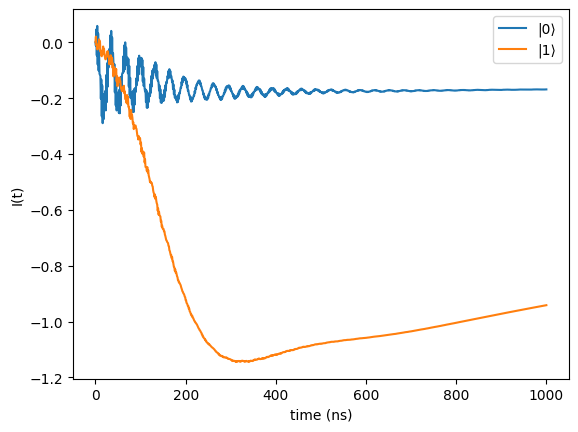

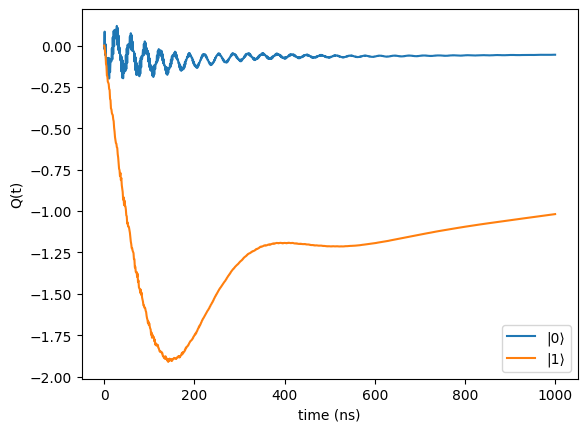

In [22]:
# ──────────────────────────────────────────────────────────────
# 4.  Extract I / Q traces 
# ──────────────────────────────────────────────────────────────


# quick plot
import matplotlib.pyplot as plt
tlist_meas = np.linspace(0, meas_args['t_meas'], meas_args['t_meas']+1)

plt.figure(); 
plt.plot(tlist_meas, I_0, label='|0⟩')
plt.plot(tlist_meas, I_1, label='|1⟩')
plt.xlabel("time (ns)"); plt.ylabel("I(t)"); plt.legend(); plt.show()

plt.figure(); 
plt.plot(tlist_meas, Q_0, label='|0⟩')
plt.plot(tlist_meas, Q_1, label='|1⟩')
plt.xlabel("time (ns)"); plt.ylabel("Q(t)"); plt.legend(); plt.show()

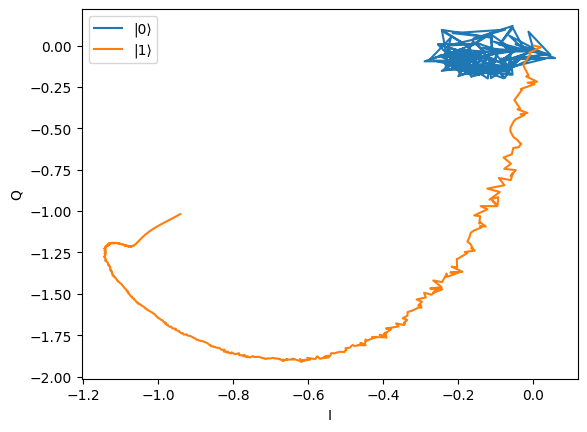

In [23]:
plt.figure(); 
plt.plot(I_0, Q_0, label='|0⟩')
plt.plot(I_1, Q_1, label='|1⟩')
plt.xlabel("I"); plt.ylabel("Q"); plt.legend(); plt.show()